In [1]:
# Импорт библиотек для обработки данных
import urllib.parse
import requests
import scipy.stats as stats
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

### Функция для чтения CSV-файла с Яндекс Диска, используя публичный URL и заданный разделитель:

In [3]:
def read_yd_csv(url_groups, separator):
    """
Параметры:
    - url_groups (str): Публичный URL CSV-файла на Яндекс Диске.
    - separator (str): Разделитель, используемый в CSV-файле.
Возвращает:
    - df (DataFrame): DataFrame, созданный из загруженного CSV-файла.
    """
    # Базовый URL для доступа к Яндекс Диску
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Создаем конечный URL для загрузки файла,
    # объединяя базовый URL и параметры запроса с использованием функции urlencode() из модуля urllib.parse
    final_url_groups = base_url + urllib.parse.urlencode(dict(public_key=url_groups))  
    
    # Делаю запрос к API Яндекс Диска для загрузки файла, используя полученный конечный URL
    response_groups = requests.get(final_url_groups)  
    
    # Функция requests.get() возвращает ответ в формате JSON, из которого извлекается URL для скачивания файла ('href')
    download_url_groups = response_groups.json()['href']
    
    # Чтение CSV-файла с использованием полученного URL и заданного разделителя
    df = pd.read_csv(download_url_groups, sep=separator)
    
    return df

# EDA - Разведочный анализ данных
**Считываем данные и проверям на наличие пустых ячеек, дубликатов, выбросов, смотрим на типы данных и размер датафрейма**

In [5]:
# Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль(базовая), B – целевая группа(новая механика)) 
groups = read_yd_csv('https://disk.yandex.ru/d/wcEqLACHAsRzyg', ';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.shape

(74484, 2)

In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

In [8]:
groups.duplicated().sum()

0

In [9]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [10]:
# Посмотрим на кол-во человек в тестируемых группах
groups.value_counts('grp')

grp
B    59813
A    14671
Name: count, dtype: int64

In [11]:
# Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
group_add = read_yd_csv('https://disk.yandex.ru/d/BfAmQUOSRNjFOg', ',')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
group_add.shape

(92, 2)

In [13]:
group_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
group_add.duplicated().sum()

0

In [15]:
group_add.nunique()

id     92
grp     2
dtype: int64

In [16]:
group_add.value_counts('grp')

grp
B    70
A    22
Name: count, dtype: int64

In [17]:
# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = read_yd_csv('https://disk.yandex.ru/d/Rx03WXIdBAvvGg', ',')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
active_studs.shape

(8341, 1)

In [19]:
active_studs.dtypes

student_id    int64
dtype: object

In [37]:
active_studs.duplicated().sum()

0

In [39]:
active_studs.nunique()

student_id    8341
dtype: int64

In [41]:
# Файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = read_yd_csv('https://disk.yandex.ru/d/OnSwJLsKcQcnzg', ';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [43]:
checks.shape

(541, 2)

In [45]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [47]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [49]:
# посмотрим на суммы оплаты
# мин. сумма - 199 у.е.
# макс. сумма - 4650 у.е
checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


### В датафреймах нет пропусков, столбцы приведены к нужным типам данных, все значения уникальны, без дублей
#### В а/б тестировании участвует 74484 пользователя, из них 14671 в группе А и 59813 в группе В.
#### За время теста была 541 оплата, с минимальной и максимальной суммой оплаты 199 и 4650 у.е. соответственно

In [52]:
# объединяем датафреймы с id всех пользователей а/б теста
all_in_ab = groups.merge(group_add, on = ['id', 'grp'], how = 'outer')
all_in_ab.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [53]:
all_in_ab.nunique()

id     74576
grp        2
dtype: int64

In [54]:
all_in_ab.isna().sum()

id     0
grp    0
dtype: int64

In [55]:
# сделаем новую колонку в дф с юзерами, которые заходили во время а/б теста
# чтобы далее соединить с дф всех юзеров и посмотреть долю активных
active_studs['is_active'] = 'active'
active_studs = active_studs.rename(columns = {'student_id' : 'id'})
active_studs.head()

,id,is_active
0,581585,active
1,5723133,active
2,3276743,active
3,4238589,active
4,4475369,active


In [56]:
# соединяем дф и заполняем пустые ячейки значением 'not_active'
all_in_ab = all_in_ab.merge(active_studs, on = 'id', how = 'left')
all_in_ab = all_in_ab.fillna('not_active')

In [57]:
all_in_ab.head()

,id,grp,is_active
0,1489,B,not_active
1,1627,A,active
2,1768,B,not_active
3,1783,B,not_active
4,1794,A,not_active


In [58]:
# меняем student_id на id, для соединения с дф all_in_ab
checks = checks.rename(columns = {'student_id' : 'id'})
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [59]:
# объединяем датафрейм всех участников а/б теста и датафрейм с оплатами
all_in_ab = all_in_ab.merge(checks, on = 'id', how = 'left').fillna(0)

In [60]:
all_in_ab

,id,grp,is_active,rev
0,1489,B,not_active,0.0
1,1627,A,active,990.0
2,1768,B,not_active,0.0
3,1783,B,not_active,0.0
4,1794,A,not_active,0.0
...,...,...,...,...
74571,200247820,B,not_active,0.0
74572,201032527,B,not_active,0.0
74573,201067612,B,not_active,0.0
74574,201067653,B,not_active,0.0


In [61]:
# дф соединились верно, кол-во строк checks совпало с кол-вом оплат в all_in_ab
all_in_ab.query('rev > 0').count()

id           541
grp          541
is_active    541
rev          541
dtype: int64

In [62]:
# проверим, были ли оплаты у неактивных пользователей
all_in_ab.query("is_active == 'not_active' and rev > 0")

,id,grp,is_active,rev
39,3185,B,not_active,690.0
121,25973,B,not_active,690.0
125,26280,B,not_active,690.0
223,100645,B,not_active,630.0
254,102534,B,not_active,580.0
...,...,...,...,...
72452,5291900,B,not_active,199.0
72753,5331842,B,not_active,290.0
73632,5486319,B,not_active,199.0
74049,5562806,B,not_active,398.0


#### 149 id не заходили в продукт во время а/б теста, при этом совершили покупку. Это может быть какая-то отложенная/подписочная оплата или же ошибка, но так как у меня нет полной информации о продукте, я предположу, что это ошибка в данных и исключу эти данные из датафрейма

In [64]:
all_in_ab = all_in_ab.drop(all_in_ab[(all_in_ab.is_active == 'not_active') & (all_in_ab.rev > 0)].index)

In [65]:
all_in_ab.head()

,id,grp,is_active,rev
0,1489,B,not_active,0.0
1,1627,A,active,990.0
2,1768,B,not_active,0.0
3,1783,B,not_active,0.0
4,1794,A,not_active,0.0


In [66]:
all_in_ab.shape

(74427, 4)

74576 - 149 = 74427, значит мы верно удалили строки с ошибками

> При оценке результатов A/B теста важно учитывать всех пользователей, которые были выбраны для участия в тесте, включая и неактивных пользователей. Это поможет избежать искажений и получить более объективные результаты. Важно учитывать всю выборку, чтобы избежать ошибок в интерпретации данных. **(ИИ-учитель)**

Я не исключаю неактивных пользователей из датафрейма.

# Расчёт метрик, поиск статистически значимой разницы и визуализация

#### Для анализа я выбрала следующие метрики: 
**CR (Конверсия)** = (кол-во покупок / кол-во всех пользователей) * 100  
процент клиентов, которые совершили хотя бы один заказ после попадания в участники теста  
**AvgCheck (Средний чек)** = выручка / кол-во покупателей  
выручка за время тестирования, деленная на количество совершенных заказов  

## 1. Для расчета конверсии (CR) сформирую таблицу сопряженности

In [72]:
# создаю таблицу, где столбец rev делаю категориальной переменной, для применения теста независимости Хи-квадрат
all_in_ab_categorical = all_in_ab.copy()
all_in_ab_categorical['rev'] =  np.where(all_in_ab_categorical['rev'] > 0, 'yes', 'no')

In [73]:
all_in_ab_categorical.head()

,id,grp,is_active,rev
0,1489,B,not_active,no
1,1627,A,active,yes
2,1768,B,not_active,no
3,1783,B,not_active,no
4,1794,A,not_active,no


In [74]:
# формируем таблицу, с помощью которой посчитаем конверсию
table = all_in_ab_categorical.groupby(['grp', 'rev']) \
                            .agg({'rev' : 'count'}) \
                            .rename(columns = {'rev': 'count'}) \
                            .reset_index()

In [75]:
table

,grp,rev,count
0,A,no,14586
1,A,yes,78
2,B,no,59449
3,B,yes,314


In [76]:
# выводим конверсию
print('CR контрольной группы А: ' + str(((table['count'][1] / table['count'][0]) * 100).round(5)))
print('CR целевой группы В: ' + str(((table['count'][3] / table['count'][2]) * 100).round(5)))

CR контрольной группы А: 0.53476
CR целевой группы В: 0.52818


### На первый взгляд конверсии отличаются незначительно. Убедиться в этом или опровергнуть нам поможет критерий согласия Пирсона.  
#### Сформулируем гипотезы:  
**Н0**: конверсия не имеет стат. значимых различий (нет влияния новой механики оплаты)  
**Н1**: конверсия значимо отличается (влияние механики оплаты значимо)

In [78]:
# создаем сводную таблицу для реализации теста Хи-квадрата
pivot_table = table.pivot(index = 'grp', columns = 'rev', values = 'count')
pivot_table

rev,no,yes
grp,,
A,14586,78
B,59449,314


In [79]:
# применяем функцию Хи-квадрат
chi2, p, dof, ex = stats.chi2_contingency(pivot_table)

In [80]:
# выведем значение p_value и примем верную гипотезу
print(f'p-value = {p}')
if p > 0.05:
    print('Конверсия не имеет стат. значимых различий, принимаем гипотезу Н0 (Новая механика не влияет на CR)')
else:
    print('Отвергаем гипотезу Н0, новая механика влияет на конверсию')

p-value = 0.9729739774584535
Конверсия не имеет стат. значимых различий, принимаем гипотезу Н0 (Новая механика не влияет на CR)


## 2. AvgCheck (Средний чек) = выручка / кол-во покупателей

In [82]:
# соберем дф с покупателями
avg_ch = all_in_ab.query("rev > 0")
avg_ch

,id,grp,is_active,rev
1,1627,A,active,990.0000
220,100300,B,active,990.0000
320,108270,B,active,290.0000
3779,264473,B,active,1900.0001
4187,274352,B,active,690.0000
...,...,...,...,...
74365,5645737,B,active,1900.0000
74381,5651566,B,active,1900.0000
74402,5662322,B,active,1900.0000
74452,5681918,B,active,1900.0000


In [83]:
# кол-во покупателей в группах
avg_ch.value_counts('grp')

grp
B    314
A     78
Name: count, dtype: int64

In [84]:
# выведем значения среднего чека для групп
print('Средний чек группы А: ', avg_ch.query("grp == 'A'").rev.mean().round(2))
print('Средний чек группы В: ', avg_ch.query("grp == 'B'").rev.mean().round(2))

Средний чек группы А:  933.59
Средний чек группы В:  1257.88


**По значениям среднего чека видим, что они достаточно отличаются (примерно на 300 у.е.)  
Дополнительно сравним с помощью графика:**

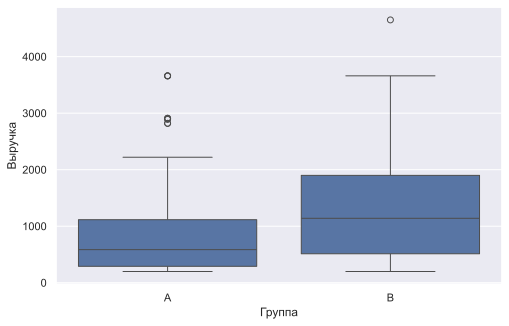

In [86]:
# построим боксплот график и посмотрим на распределение сумм покупок пользователей
sns.boxplot(data = avg_ch, x = 'grp', y = 'rev')
plt.xlabel('Группа')
plt.ylabel('Выручка')
plt.show()

По графику выше мы видим, что боксплот группы В (его медиана, 25 и 75 перцентили) выше группы А, это значит, что пользователи целевой группы В совершали покупки на большие суммы, чем контрольная группа А.    

Далее **проверим, имеют ли группы статзначимую разницу по метрике Среднего чека**

In [88]:
# Построим распределение чеков по группам
ab_a = avg_ch.query("grp == 'A'")
ab_b = avg_ch.query("grp == 'B'")

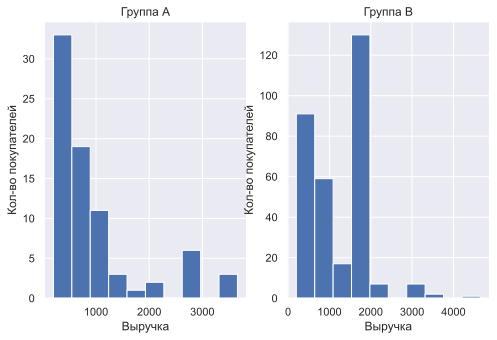

In [89]:
# строим график
fig, axes = plt.subplots(1, 2)
axes[0].hist(ab_a.rev)
axes[0].set_title('Группа А')
axes[0].set(xlabel = 'Выручка', ylabel = 'Кол-во покупателей')

axes[1].hist(ab_b.rev)
axes[1].set_title('Группа В')
axes[1].set(xlabel = 'Выручка', ylabel = 'Кол-во покупателей')
plt.show()

По графику распределения видим, что в группе В большинство чеков в районе 2000 у.е. по сравнению с группой А (чек меньше 1000 у.е.)  

### Далее проверим равенство средних значений с помощью Бутстрепа

### Гипотезы:
**Н0**: Средние чеки не имеют значимой разницы (они равны)  
**Н1**: Разница в средних чеках есть

In [121]:
# функция Бутстрэпа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

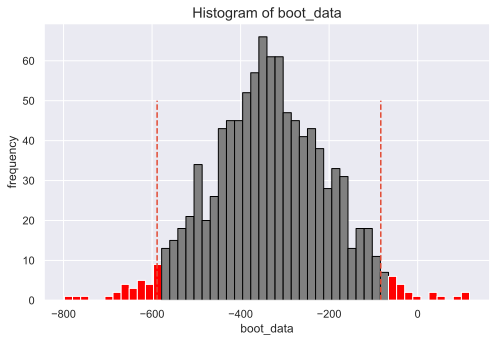

p-value:  0.011266628472313378
Доверительный интервал:                  0
0.025 -588.605781
0.975  -83.254177


In [122]:
# строим график и выводим значения
bs_avg_ch = get_bootstrap(ab_a.rev,  # числовые значения первой выборки
                            ab_b.rev)  # числовые значения второй выборки

print("p-value: ", bs_avg_ch['p_value'])
print("Доверительный интервал: ", bs_avg_ch['quants'])

#### P-value < 0.05 и доверительный интервал не включает в себя 0, значит средние чеки статистически значимо отличаются.   Отклоняем гипотезу Н0

# Итого:
В ходе изучения итогов эксперимента я выбрала для анализа следующие метрики:  
- CR (процент клиентов, которые совершили хотя бы один заказ после попадания в участники теста)  
- AvgCheck (выручка за время тестирования, деленная на количество совершенных заказов)  

Предложена новая механика оплаты услуг, а конверсия в покупку и денежные метрики отлично подходят для оценки результатов и наглядно отражают их для бизнеса.  

1. CR контрольной группы А: 0.535  
CR целевой группы В: 0.528  
В группе с новой механикой оплаты конверсия в покупку упала, по сравнению со старой механикой, но критерий Хи-квадрат не показал статзначимого влияния на конверсию.  
**На основании этой метрики мы не можем принять решение о запуске на всех пользователей**  
2. Средний чек я проверяла с помощью t-критерия Стьюдента и Бутстреп  
Средний чек группы А:  933.59  
Средний чек группы В:  1257.88  
**Чек целевой группы вырос на 300+ у.е., а критерий подтвердил статзначимость изменения метрики.**   

## Вывод:
Только средний чек показал влияние новой механики оплаты.  
Если смотреть на это как на воронку, то последний этап из активного пользователя в покупку стал лучше с новой механикой, но конверсия в покупку не изменилась. Я думаю, что **можно запустить новую механику на всех пользователей**.  
**НО**, стоит внимательно следить за метрикой конверсии (CR) и работать над её улучшением, чтобы более точно привлекать целевую аудиторию продукта.

## Функция, которая автоматически подгружает информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывает метрики.  

In [126]:
# Импорт библиотек для обработки данных
import urllib.parse
import requests

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [158]:
def read_append_count():
    """
Параметры:
    Публичные URL CSV-файла на Яндекс Диске.
Возвращает:
    Функция загружает данные и рассчитывает показатели: CR, AvgCheck.
    """
    # Базовый URL для доступа к Яндекс Диску
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Создаем конечные URL для загрузки файлов,
    # объединяя базовый URL и параметры запроса с использованием функции urlencode() из модуля urllib.parse
    final_url_groups = base_url + urllib.parse.urlencode(dict(public_key = url_groups))
    final_url_active_studs = base_url + urllib.parse.urlencode(dict(public_key = url_active_studs))
    final_url_checks = base_url + urllib.parse.urlencode(dict(public_key = url_checks))
    
    # Делаем запрос к API Яндекс Диска для загрузки файлов, используя полученные конечные URL
    response_url_groups = requests.get(final_url_groups)
    response_url_active_studs = requests.get(final_url_active_studs)
    response_url_checks = requests.get(final_url_checks)
    
    # Функция requests.get() возвращает ответ в формате JSON, из которого извлекается URL для скачивания файла ('href')
    download_url_groups = response_url_groups.json()['href']
    download_url_active_studs = response_url_active_studs.json()['href']
    download_url_checks = response_url_checks.json()['href']
    
    # Чтение CSV-файлов с использованием полученных URL и заданного разделителя
    groups = pd.read_csv(download_url_groups, sep = ';', header = 0, names = ['id', 'grp'])
    active_studs = pd.read_csv(download_url_active_studs, sep = ',', header = 0, names = ['id'])
    checks = pd.read_csv(download_url_checks, sep = ';', header = 0, names = ['id', 'rev'])
    
    # Создаю пустой датафрейм, куда добавлю всех участников а/б теста 
    all_in_ab = groups.copy()
    
    # С помощью блока try except сделаем возможность добавления доп. пользователей(groups_add) и объединим с groups
    try:
        final_url_groups_add = base_url + urllib.parse.urlencode(dict(public_key = url_groups_add))
    except NameError:
        print('Дополнительных пользователей не добавлено\n')
    else:
        response_url_groups_add = requests.get(final_url_groups_add)
        download_url_groups_add = response_url_groups_add.json()['href']
        groups_add = pd.read_csv(download_url_groups_add, sep = ',', header = 0, names = ['id', 'grp'])
        all_in_ab = all_in_ab.append(groups_add)
        print('Добавлены дополнительные пользователи\n')
        
            
    # Добавляем колонку с обозначением активности пользователя 'active'
    active_studs['is_active'] = 'active'
    
    # Объединяем данные и пустые значение заполняем 'not_active'
    all_in_ab = all_in_ab.merge(active_studs, on = 'id', how = 'left')
    all_in_ab = all_in_ab.fillna('not_active')
    
    # объединяем датафрейм всех участников а/б теста и датафрейм с оплатами
    all_in_ab = all_in_ab.merge(checks, on = 'id', how = 'left').fillna(0)
    
    # Удаляем id, которые не заходили в продукт во время а/б теста, при этом совершили покупку
    # Добавляем столбец с категориальной переменной 'is_rev'
    all_in_ab = all_in_ab.drop(all_in_ab[(all_in_ab.is_active == 'not_active') & (all_in_ab.rev > 0)].index)
    all_in_ab['is_rev'] =  np.where(all_in_ab['rev'] > 0, 'yes', 'no')
    
    # Считаем конверсию (CR)
    tab_cr = all_in_ab.groupby(['grp', 'is_rev'], as_index = False).agg({'id' : 'count'})
    pivot_tab = tab_cr.pivot(index = 'grp', columns = 'is_rev', values = 'id')
    cr = ((pivot_tab.yes / (pivot_tab.yes + pivot_tab.no)) * 100) \
                    .to_frame().reset_index()
    cr = cr.rename(columns = {cr.columns[1] : 'cr'})
    
    # Считаем средний чек (AvgCheck)
    avgch = all_in_ab.query("rev > 0").groupby('grp', as_index = False) \
                    .agg({'rev' : 'mean'}).round(2)

    return cr, avgch

In [129]:
# Для проверки возможности добавления groups_add
# Можно закомментировать код в этой ячейке и посмотреть: корректно ли работает функция 

# url_groups_add = 'https://disk.yandex.ru/d/BfAmQUOSRNjFOg'

In [130]:
# Передаем публичные URL CSV-файлой с Яндекс Диска
url_groups = 'https://disk.yandex.ru/d/wcEqLACHAsRzyg'
url_active_studs = 'https://disk.yandex.ru/d/Rx03WXIdBAvvGg'
url_checks = 'https://disk.yandex.ru/d/OnSwJLsKcQcnzg'

In [131]:
# выводим значения метрик
cr, avgch = read_append_count()
print(f"Метрики:\n\nCR (конверсия) =\n{cr}\n\n \
Avg Check (средний чек) =\n{avgch}")

Дополнительных пользователей не добавлено

Метрики:

CR (конверсия) =
  grp        cr
0   A  0.532714
1   B  0.524350

 Avg Check (средний чек) =
  grp      rev
0   A   933.59
1   B  1255.83


### 2. Реализация функции, которая будет строить графики по получаемым метрикам.

In [153]:
def draw_barplot(cr, avgch):
    """
Параметры:
    Метрики, полученные в результате предыдущей функции (CR, AvgCheck, ARPU)
Возвращает:
    3 графика с метриками
    """
    # Задаем параметры графиков, чтобы они находились в одной сетке и увеличиваем расстояние между ними
    fig, (axes1, axes2) = plt.subplots(1, 2)
    plt.subplots_adjust(wspace = 0.5)
    
    # Строим графики для метрик, задаем заголовки и названия осей
    axes1 = sns.barplot(data = cr.reset_index(), x = 'grp', y = 'cr', ax = axes1)
    axes1.set_title('CR')
    axes1.set(xlabel = 'Группа', ylabel = 'Конверсия, %')

    axes2 = sns.barplot(data = avgch.reset_index(), x = 'grp', y = 'rev', ax = axes2)
    axes2.set_title('Avg Check')
    axes2.set(xlabel = 'Группа', ylabel = 'Средний чек, у.е.')

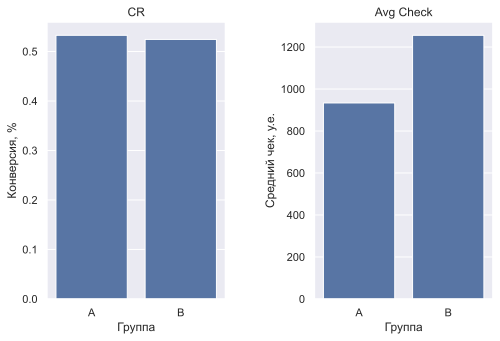

In [155]:
draw_barplot(cr, avgch)
plt.show()